In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools


In [20]:
image_path = "/Users/leopoldstevens/Documents/GitHub/CC-1/data/empty_board.png"
image_path = "/Users/leopoldstevens/Documents/GitHub/CC-1/input/board.png"



In [21]:


image = cv2.imread(image_path)
print(image.shape)
size_of_board = (image.shape[0]+image.shape[1])/2

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 50, 150, apertureSize=3)

lines = cv2.HoughLines(edges, 1, np.pi / 180, 300)



(1380, 1380, 3)


In [22]:
line_image = image.copy()
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + size_of_board * (-b))
        y1 = int(y0 + size_of_board * (a))
        x2 = int(x0 - size_of_board * (-b))
        y2 = int(y0 - size_of_board * (a))
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)


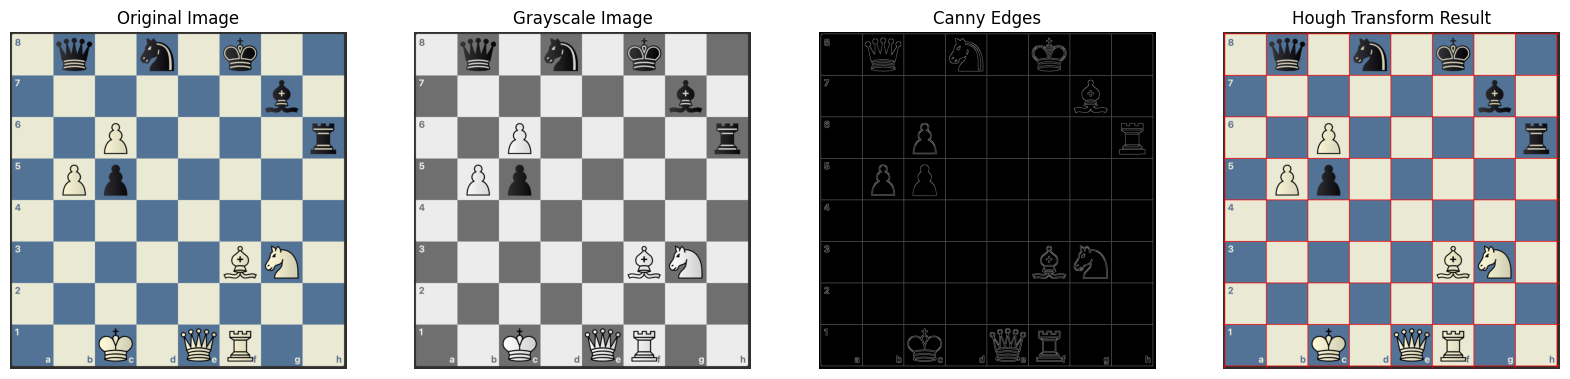

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(gray, cmap='gray')
axes[1].set_title("Grayscale Image")
axes[1].axis("off")

axes[2].imshow(edges, cmap='gray')
axes[2].set_title("Canny Edges")
axes[2].axis("off")

axes[3].imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
axes[3].set_title("Hough Transform Result")
axes[3].axis("off")

plt.show()

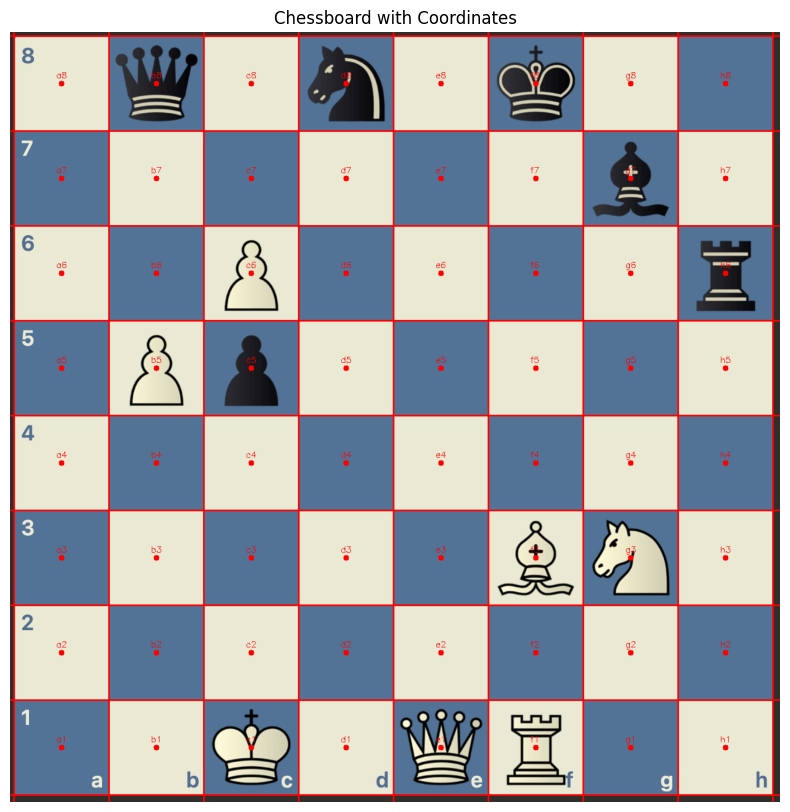

In [24]:
# Find intersections of lines
def find_intersections(lines):
    intersections = []
    if lines is None:
        return intersections
    for line1, line2 in itertools.combinations(lines, 2):
        rho1, theta1 = line1[0]
        rho2, theta2 = line2[0]
        A = np.array([
            [np.cos(theta1), np.sin(theta1)],
            [np.cos(theta2), np.sin(theta2)]
        ])
        b = np.array([[rho1], [rho2]])
        if np.linalg.det(A) != 0:  # Lines are not parallel
            x0, y0 = np.linalg.solve(A, b)
            x0, y0 = int(np.round(x0)), int(np.round(y0))
            if 0 <= x0 < image.shape[1] and 0 <= y0 < image.shape[0]:  # Within image bounds
                intersections.append((x0, y0))
    return intersections

intersections = find_intersections(lines)

# Sort intersections into a grid
def sort_intersections(intersections):
    intersections.sort(key=lambda x: (x[1], x[0]))  # Sort by y, then by x
    grid = []
    grid_size = 9  # 8x8 board has 9 lines
    for i in range(0, len(intersections), grid_size):
        row = sorted(intersections[i:i + grid_size], key=lambda x: x[0])
        grid.append(row)
    return grid

grid = sort_intersections(intersections)

# Labels for the chessboard
coordinate_labels = ["a", "b", "c", "d", "e", "f", "g", "h"]

# Draw red dots and labels on the chessboard
for i in range(len(grid) - 1):
    for j in range(len(grid[i]) - 1):
        # Get the four corners of the square
        top_left = grid[i][j]
        top_right = grid[i][j + 1]
        bottom_left = grid[i + 1][j]
        bottom_right = grid[i + 1][j + 1]
        
        # Calculate the center of the square
        center_x = (top_left[0] + top_right[0] + bottom_left[0] + bottom_right[0]) // 4
        center_y = (top_left[1] + top_right[1] + bottom_left[1] + bottom_right[1]) // 4
        
        # Label for the square
        label = f"{coordinate_labels[j]}{8 - i}"
        
        # Draw the red dot at the center
        cv2.circle(line_image, (center_x, center_y), 5, (0, 0, 255), -1)
        
        # Draw the label near the center
        cv2.putText(line_image, label, (center_x - 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Display the final image with labels
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Chessboard with Coordinates")
plt.axis("off")
plt.show()


In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChessPieceCNN(nn.Module):
    def __init__(self, num_classes=13):  # Adjust the number of classes as needed
        super(ChessPieceCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 32 * 32, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

In [80]:
import os
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

class ChessPieceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {
            'black_bishop': 0, 'black_king': 1, 'black_queen': 2, 'black_knight': 3, 'black_rook': 4,
            'black_pawn': 5, 'white_bishop': 6, 'white_king': 7, 'white_queen': 8, 'white_knight': 9,
            'white_rook': 10, 'white_pawn': 11, 'empty': 12
        }

        self.load_images(os.path.join(root_dir, 'black'))
        self.load_images(os.path.join(root_dir, 'white'))
        self.load_images(os.path.join(root_dir, 'empty'), is_empty=True)
    
    def load_images(self, color_dir, is_empty=False):
        if is_empty:
            for img_name in os.listdir(color_dir):
                img_path = os.path.join(color_dir, img_name)
                if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure it's a valid image file
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx['empty'])
        else:
            color_label = os.path.basename(color_dir)  # Get color from the path (black or white)
            for label_name in os.listdir(color_dir):
                label_dir = os.path.join(color_dir, label_name)
                if os.path.isdir(label_dir):  # Ensure it's a directory
                    for img_name in os.listdir(label_dir):
                        img_path = os.path.join(label_dir, img_name)
                        if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure it's a valid image file
                            full_label_name = f"{color_label}_{label_name}"
                            self.images.append(img_path)
                            self.labels.append(self.class_to_idx[full_label_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        
        image = Image.open(img_path).convert('RGB')

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


In [81]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [82]:
train_dataset = ChessPieceDataset(root_dir='data/train', transform=train_transform)
test_dataset = ChessPieceDataset(root_dir='data/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for idx in range(5): 
    img, lbl = train_dataset[idx]
    print(f"Image path: {train_dataset.images[idx]}, Label: {train_dataset.labels[idx]}, Class name: {list(train_dataset.class_to_idx.keys())[lbl]}")

Image path: data/train/black/bishop/augmented_screenshot_16 2024-06-06 at 17.48.00.png, Label: 0, Class name: black_bishop
Image path: data/train/black/bishop/88.png, Label: 0, Class name: black_bishop
Image path: data/train/black/bishop/77.png, Label: 0, Class name: black_bishop
Image path: data/train/black/bishop/63.png, Label: 0, Class name: black_bishop
Image path: data/train/black/bishop/augmented_screenshot_7 2024-06-06 at 17.47.50.png, Label: 0, Class name: black_bishop


In [83]:
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize the model, loss function, and optimizer
model = ChessPieceCNN(num_classes=13)  # Including 'empty' as a class
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and testing loss and accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

best_test_acc = 0
best_train_acc = 0

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

# Training and testing loop
for epoch in range(100):  # Number of epochs
    model.train()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += calculate_accuracy(outputs, labels) * labels.size(0)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_corrects / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Confusion matrix for training
    cm_train = confusion_matrix(all_labels, all_preds)
    print(f"\nEpoch {epoch+1} Training Confusion Matrix")
    print(cm_train)

    # Evaluate on test set
    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            test_running_corrects += calculate_accuracy(outputs, labels) * labels.size(0)
            all_test_preds.extend(outputs.argmax(1).cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())
    
    test_loss = test_running_loss / len(test_loader)
    test_accuracy = test_running_corrects / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Save the model if the test accuracy is higher, or if it's equal and the training accuracy is higher
    if test_accuracy > best_test_acc or (test_accuracy == best_test_acc and train_accuracy > best_train_acc):
        best_test_acc = test_accuracy
        best_train_acc = train_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        epoch_saved = epoch

    # Confusion matrix for testing
    cm_test = confusion_matrix(all_test_labels, all_test_preds)
    print(f"\nEpoch {epoch+1} Testing Confusion Matrix")
    print(cm_test)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print('Finished Training')
print(f'Model saved at train_acc {best_train_acc}, and test_acc {best_test_acc}, at epoch {epoch_saved}')



Epoch 1 Training Confusion Matrix
[[ 41   1   4   2   6  52  14   3   0   1   2   7   5]
 [  2  23   0   8   3  18   5   2   2   4   2   2   0]
 [  5   2  19   9   8  12   7   1   0   3   3   0   1]
 [ 10   5   2  72   4  27   7   0   0   6   2   3   3]
 [ 13   0   2   4  28  55  19   3   2   2   6   8   1]
 [ 13   1   3  11   6 125  27   3   0   5  10  17   4]
 [  6   0   2   1   3  27  41   3   2   9  26  17   2]
 [  2   0   1   0   2   2  23  11   0   7  10  11   0]
 [  1   4   1   0   6   2  16   0  14   7  12   7   0]
 [  1   0   1   2   0  11  21   0   2  75   7  20   0]
 [  1   0   2   0   5  13  30   3   5  16  49  14   1]
 [  1   0   3   1   3  23  26   0   1  21  14  68   1]
 [  7   0   3   6   0   8   4   1   1   9   4  11  46]]

Epoch 1 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 2 0]]
Epoch 1, Train Loss: 2.04

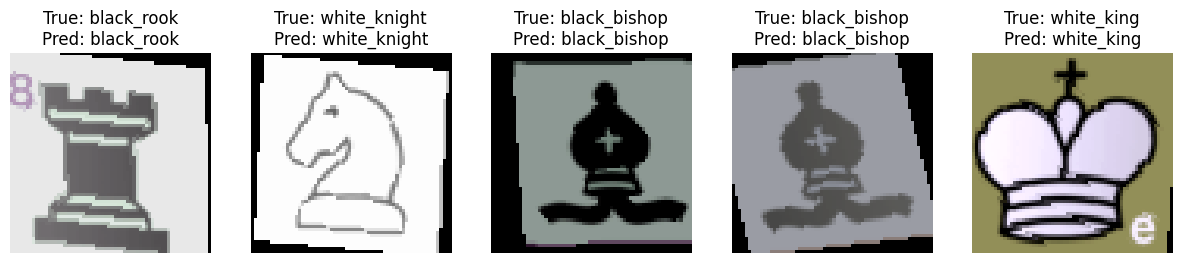

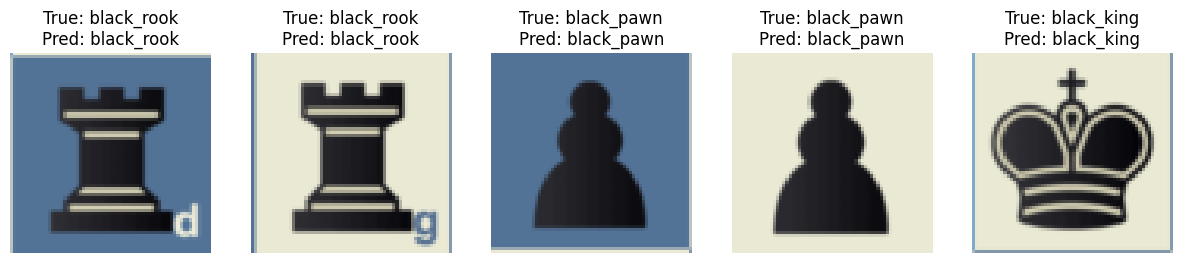

In [84]:
import numpy as np

def show_examples(model, loader, class_names, transform):
    model.eval()
    images, labels = next(iter(loader))
    images = images[:5] 
    labels = labels[:5]
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        ax = fig.add_subplot(1, 5, i+1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}")
        ax.axis('off')
    plt.show()

class_names = ['black_bishop', 'black_king', 'black_queen', 'black_knight', 'black_rook',
            'black_pawn', 'white_bishop', 'white_king', 'white_queen', 'white_knight',
            'white_rook', 'white_pawn', 'empty']
show_examples(model, train_loader, class_names, train_transform)
show_examples(model, test_loader, class_names, test_transform)


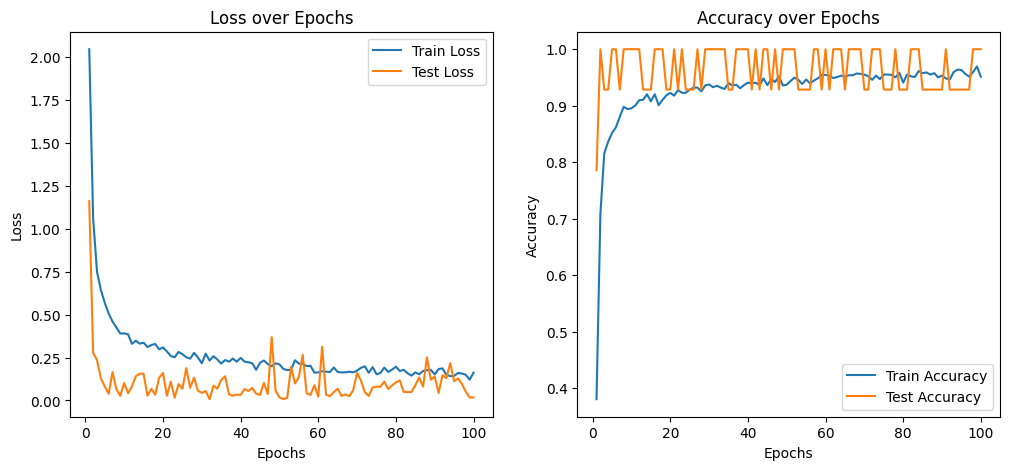

In [85]:
epochs = range(1, 101)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

In [ ]:
# import os
# from PIL import Image
# import numpy as np

# def create_color_image(color, size=(64, 64)):
#     """Create a single-color image."""
#     image = Image.fromarray(np.full((size[1], size[0], 3), color, dtype=np.uint8))
#     return image

# def save_color_images(colors, save_dir, size=(64, 64), num_images=100):
#     """Save multiple single-color images."""
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

#     for i in range(num_images):
#         for color_name, color_value in colors.items():
#             image = create_color_image(color_value, size)
#             file_name = f"{color_name}_{i}.png"
#             file_path = os.path.join(save_dir, file_name)
#             image.save(file_path)

# # Define colors and their names
# colors = {
#     'black': (0, 0, 0),
#     'white': (255, 255, 255),
#     'red': (255, 0, 0),
#     'green': (0, 255, 0),
#     'blue': (0, 0, 255)
# }

# # Directory to save the generated images
# save_dir = 'data/train/empty'


# save_color_images(colors, save_dir, size=(64, 64), num_images=20)


In [65]:
# import os
# import shutil
# from PIL import Image, ImageEnhance, ImageOps
# import random

# def apply_transform(image):
#     """Apply a random transformation to the image."""
#     # Randomly choose a transformation to apply
#     transforms = [
#         lambda img: img.rotate(random.uniform(-1, 1)), 
#         lambda img: img.rotate(random.uniform(-2, 2)),
#         lambda img: img.rotate(random.uniform(-3, 3)),
#         lambda img: img.rotate(random.uniform(-4, 4)),
#         lambda img: img.rotate(random.uniform(-5, 5)),
#         lambda img: ImageEnhance.Contrast(img).enhance(random.uniform(0.5, 1.5)),  # Random contrast
#         lambda img: ImageEnhance.Brightness(img).enhance(random.uniform(0.5, 1.5)),  # Random brightness
#         lambda img: ImageEnhance.Color(img).enhance(random.uniform(0.5, 1.5)),  # Random color enhancement
#         lambda img: ImageOps.mirror(img),  # Horizontal flip
#     ]
#     transform = random.choice(transforms)
#     return transform(image)

# def duplicate_and_transform_images(root_dir, iter):
#     for color in ['black', 'white']:
#         color_dir = os.path.join(root_dir, color)
#         for piece in os.listdir(color_dir):
#             piece_dir = os.path.join(color_dir, piece)
#             if os.path.isdir(piece_dir):
#                 for img_name in os.listdir(piece_dir):
#                     if img_name.startswith("Screenshot"):
#                         img_path = os.path.join(piece_dir, img_name)
#                         with Image.open(img_path) as img:
#                             # Apply transformation
#                             transformed_img = apply_transform(img)
#                             # Save the new image
#                             new_img_name = img_name.replace("Screenshot", f"augmented_screenshot_{iter}")
#                             new_img_path = os.path.join(piece_dir, new_img_name)
#                             transformed_img.save(new_img_path)

# # Define the root directory
# root_dir = '/Users/leopoldstevens/Documents/GitHub/CC-1/data/train'

# for i in range(50):
#     duplicate_and_transform_images(root_dir, i)


Cell (0, 1): black_queen with probability 0.91
Cell (0, 3): black_knight with probability 0.97
Cell (0, 5): black_king with probability 0.98
Cell (1, 6): black_bishop with probability 0.95
Cell (2, 2): white_pawn with probability 1.00
Cell (2, 7): black_rook with probability 0.96
Cell (3, 1): white_pawn with probability 1.00
Cell (3, 2): black_pawn with probability 0.96
Cell (5, 5): white_bishop with probability 1.00
Cell (5, 6): white_knight with probability 1.00
Cell (7, 2): white_king with probability 0.99
Cell (7, 4): white_queen with probability 0.92
Cell (7, 5): white_rook with probability 1.00


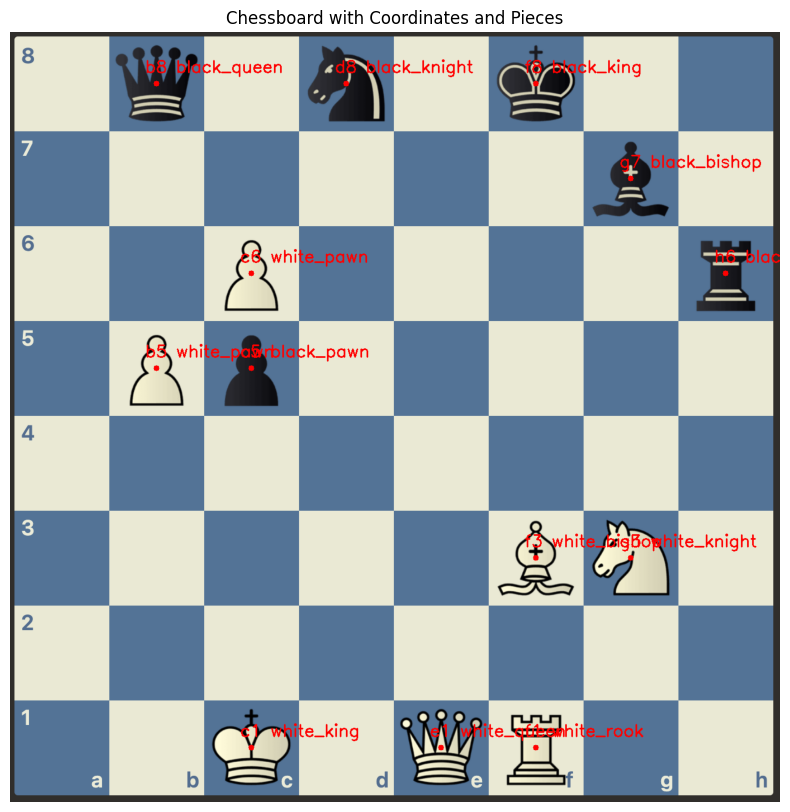

In [266]:
from torchvision.transforms import functional as TF

model = ChessPieceCNN(num_classes=13)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Define a function to process each cell
def process_cell(image, model, transform):
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1).squeeze(0)
    return probabilities

# Find intersections of lines
def find_intersections(lines, image_shape):
    intersections = []
    if lines is None:
        return intersections
    for line1, line2 in itertools.combinations(lines, 2):
        rho1, theta1 = line1[0]
        rho2, theta2 = line2[0]
        A = np.array([
            [np.cos(theta1), np.sin(theta1)],
            [np.cos(theta2), np.sin(theta2)]
        ])
        b = np.array([[rho1], [rho2]])
        if np.linalg.det(A) != 0:  # Lines are not parallel
            x0, y0 = np.linalg.solve(A, b)
            x0, y0 = int(np.round(x0)), int(np.round(y0))
            if 0 <= x0 < image_shape[1] and 0 <= y0 < image_shape[0]:  # Within image bounds
                intersections.append((x0, y0))
    return intersections

# Sort intersections into a grid
def sort_intersections(intersections):
    intersections.sort(key=lambda x: (x[1], x[0]))  # Sort by y, then by x
    grid = []
    grid_size = 9  # 8x8 board has 9 lines
    for i in range(0, len(intersections), grid_size):
        row = sorted(intersections[i:i + grid_size], key=lambda x: x[0])
        grid.append(row)
    return grid

# Function to classify each cell in the chessboard
def classify_chessboard(image_path, model, transform):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 300)

    intersections = find_intersections(lines, image.shape)
    grid = sort_intersections(intersections)

    # Process each cell
    results = {}
    for i in range(8):
        for j in range(8):
            # Get the four corners of the square
            top_left = grid[i][j]
            top_right = grid[i][j + 1]
            bottom_left = grid[i + 1][j]
            bottom_right = grid[i + 1][j + 1]
            
            # Calculate the bounding box of the cell
            cell_image = image[top_left[1]:bottom_left[1], top_left[0]:top_right[0]]
            cell_image_pil = TF.to_pil_image(cell_image)
            probabilities = process_cell(cell_image_pil, model, transform)
            results[(i, j)] = probabilities
    
    return results, grid

# Example usage
image_path = "/Users/leopoldstevens/Documents/GitHub/CC-1/input/board.png"
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
results, grid = classify_chessboard(image_path, model, transform)

# Define the class names
class_names = ['black_bishop', 'black_king', 'black_queen', 'black_knight', 'black_rook', 'black_pawn',
               'white_bishop', 'white_king', 'white_queen', 'white_knight', 'white_rook', 'white_pawn', 'empty']

# Print results and visualize
line_image = cv2.imread(image_path)
coordinate_labels = ["a", "b", "c", "d", "e", "f", "g", "h"]

for coord, probs in results.items():
    piece_probs = {class_names[i]: probs[i].item() for i in range(len(class_names))}
    max_prob_piece = max(piece_probs, key=piece_probs.get)
    if max_prob_piece != 'empty':
        print(f"Cell {coord}: {max_prob_piece} with probability {piece_probs[max_prob_piece]:.2f}")
        
        top_left = grid[coord[0]][coord[1]]
        top_right = grid[coord[0]][coord[1] + 1]
        bottom_left = grid[coord[0] + 1][coord[1]]
        bottom_right = grid[coord[0] + 1][coord[1] + 1]
        
        center_x = (top_left[0] + top_right[0] + bottom_left[0] + bottom_right[0]) // 4
        center_y = (top_left[1] + top_right[1] + bottom_left[1] + bottom_right[1]) // 4
        
        label = f"{coordinate_labels[coord[1]]}{8 - coord[0]}"
        
        cv2.circle(line_image, (center_x, center_y), 5, (0, 0, 255), -1)
        cv2.putText(line_image, f"{label} {max_prob_piece}", (center_x - 20, center_y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Chessboard with Coordinates and Pieces")
plt.axis("off")
plt.show()

In [268]:
import chess
import chess.engine

def setup_board(results, class_names):
    board = chess.Board()
    board.clear()

    piece_map = {
        'black_bishop': chess.BISHOP,
        'black_king': chess.KING,
        'black_queen': chess.QUEEN,
        'black_knight': chess.KNIGHT,
        'black_rook': chess.ROOK,
        'black_pawn': chess.PAWN,
        'white_bishop': chess.BISHOP,
        'white_king': chess.KING,
        'white_queen': chess.QUEEN,
        'white_knight': chess.KNIGHT,
        'white_rook': chess.ROOK,
        'white_pawn': chess.PAWN
    }

    color_map = {
        'black_bishop': chess.BLACK,
        'black_king': chess.BLACK,
        'black_queen': chess.BLACK,
        'black_knight': chess.BLACK,
        'black_rook': chess.BLACK,
        'black_pawn': chess.BLACK,
        'white_bishop': chess.WHITE,
        'white_king': chess.WHITE,
        'white_queen': chess.WHITE,
        'white_knight': chess.WHITE,
        'white_rook': chess.WHITE,
        'white_pawn': chess.WHITE
    }

    for coord, probs in results.items():
        piece_probs = {class_names[i]: probs[i].item() for i in range(len(class_names))}
        max_prob_piece = max(piece_probs, key=piece_probs.get)
        if max_prob_piece != 'empty':
            piece = piece_map[max_prob_piece]
            color = color_map[max_prob_piece]
            rank = 7 - coord[0]
            file = coord[1]
          
            square = chess.square(file, rank)
            board.set_piece_at(square, chess.Piece(piece, color))

    
    return board

# Define the class names
class_names = ['black_bishop', 'black_king', 'black_queen', 'black_knight', 'black_rook', 'black_pawn',
               'white_bishop', 'white_king', 'white_queen', 'white_knight', 'white_rook', 'white_pawn', 'empty']

results, _ = classify_chessboard(image_path, model, transform)

board = setup_board(results, class_names)
print(board)

stockfish_path = '/usr/local/bin/stockfish'

def get_best_moves(engine, board, depth=15, multipv=5):
    analysis = engine.analyse(board, chess.engine.Limit(depth=depth), multipv=multipv)
    best_moves = [entry['pv'][0] for entry in analysis]
    return best_moves

def describe_move(board, move):
    piece = board.piece_at(move.from_square)
    piece_name = piece.symbol().upper() if piece.color == chess.WHITE else piece.symbol().lower()
    from_square = chess.square_name(move.from_square)
    to_square = chess.square_name(move.to_square)
    target_piece = board.piece_at(move.to_square)
    
    if target_piece:
        target_piece_name = target_piece.symbol().upper() if target_piece.color == chess.WHITE else target_piece.symbol().lower()
        return f"{piece_name} at {from_square} takes {target_piece_name} at {to_square}"
    else:
        return f"{piece_name} at {from_square} goes to {to_square}"

with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
    # Determine the current player
    current_player = "White" if board.turn == chess.WHITE else "Black"
    
    # Best moves for the current player
    best_moves_current = get_best_moves(engine, board)
    print(f"Best moves for {current_player}:")
    for i, move in enumerate(best_moves_current):
        descriptive_move = describe_move(board, move)
        print(f"{i + 1}. {descriptive_move}")
    
    # Switch the turn to the other player
    board.push(chess.Move.null())
    
    # Determine the other player
    other_player = "White" if board.turn == chess.WHITE else "Black"
    
    # Best moves for the other player
    best_moves_other = get_best_moves(engine, board)
    print(f"\nBest moves for {other_player}:")
    for i, move in enumerate(best_moves_other):
        descriptive_move = describe_move(board, move)
        print(f"{i + 1}. {descriptive_move}")

    # Undo the null move to restore the original turn
    board.pop()



. q . n . k . .
. . . . . . b .
. . P . . . . r
. P p . . . . .
. . . . . . . .
. . . . . B N .
. . . . . . . .
. . K . Q R . .


Not transmitting history with null moves to UCI engine


Best moves for White:
1. P at c6 goes to c7
2. B at f3 goes to h5
3. B at f3 goes to d5
4. N at g3 goes to h5
5. Q at e1 goes to e3

Best moves for Black:
1. n at d8 goes to f7
2. q at b8 goes to f4
3. r at h6 goes to f6
4. b at g7 goes to e5
5. b at g7 goes to b2


Not transmitting history with null moves to UCI engine


Best moves for White:
1. P at c6 goes to c7
2. B at f3 goes to h5
3. B at f3 goes to d5
4. N at g3 goes to h5
5. Q at e1 goes to e3

Best moves for Black:
1. n at d8 goes to f7
2. q at b8 goes to f4
3. r at h6 goes to f6
4. b at g7 goes to e5
5. b at g7 goes to b2


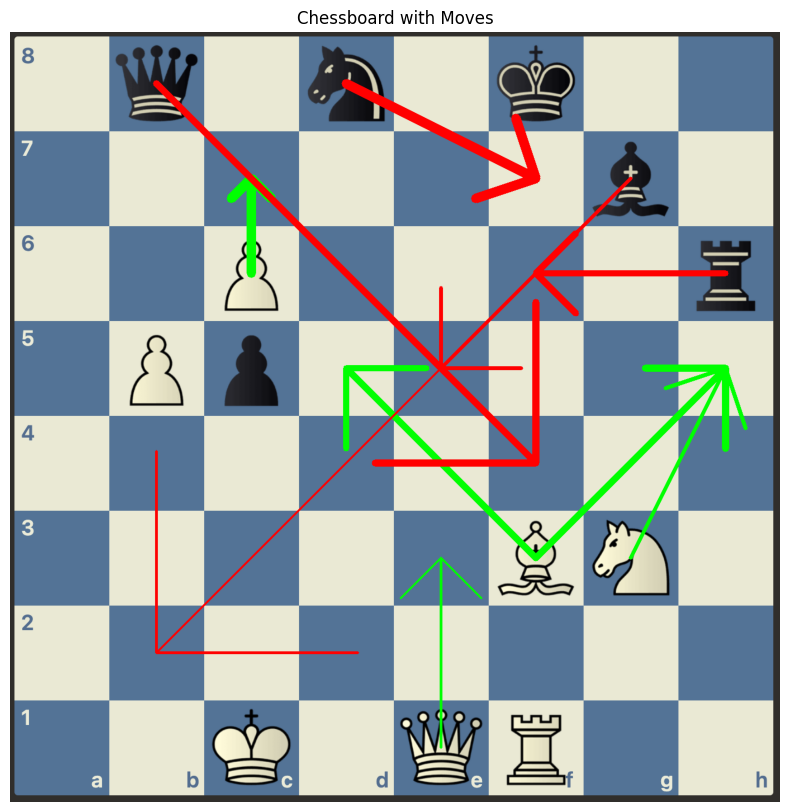

In [275]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import chess
import chess.engine

def draw_arrows(image_path, best_moves_current, best_moves_other, board, grid):
    # Load the image
    image = cv2.imread(image_path)
    
    # Define a function to get the center of a square
    def get_square_center(rank, file):
        top_left = grid[7-rank][file]
        bottom_right = grid[7-rank+1][file+1]
        center_x = (top_left[0] + bottom_right[0]) // 2
        center_y = (top_left[1] + bottom_right[1]) // 2
        return center_x, center_y

    # Draw arrows for the current player (green)
    for i, move in enumerate(best_moves_current):
        from_square = move.from_square
        to_square = move.to_square
        
        from_rank = chess.square_rank(from_square)
        from_file = chess.square_file(from_square)
        to_rank = chess.square_rank(to_square)
        to_file = chess.square_file(to_square)
        
        from_center = get_square_center(from_rank, from_file)
        to_center = get_square_center(to_rank, to_file)
        
        # Draw the arrow
        color = (0, 255, 0)  # Green for the current player
        thickness = max(15 - 3*i, 1)  # Thicker for the best move, decreasing for subsequent moves
        cv2.arrowedLine(image, from_center, to_center, color, thickness, tipLength=0.3)

    # Draw arrows for the opponent (red)
    for i, move in enumerate(best_moves_other):
        from_square = move.from_square
        to_square = move.to_square
        
        from_rank = chess.square_rank(from_square)
        from_file = chess.square_file(from_square)
        to_rank = chess.square_rank(to_square)
        to_file = chess.square_file(to_square)
        
        from_center = get_square_center(from_rank, from_file)
        to_center = get_square_center(to_rank, to_file)
        
        # Draw the arrow
        color = (0, 0, 255)  # Red for the opponent
        thickness = max(15 - 3*i, 1)  # Thicker for the best move, decreasing for subsequent moves
        cv2.arrowedLine(image, from_center, to_center, color, thickness, tipLength=0.3)
    
    # Display the final image with arrows
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Chessboard with Moves")
    plt.axis("off")
    plt.show()

# Example usage
image_path = "/Users/leopoldstevens/Documents/GitHub/CC-1/input/board.png"

# Assuming the results and grid are obtained from the classify_chessboard function
# results, grid = classify_chessboard(image_path, model, transform)
# Set up the board using the results
board = setup_board(results, class_names)

# Path to the Stockfish executable
stockfish_path = '/usr/local/bin/stockfish'

# Use Stockfish to find the best moves for the current turn
with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
    # Determine the current player
    current_player = "White" if board.turn == chess.WHITE else "Black"
    
    # Best moves for the current player
    best_moves_current = get_best_moves(engine, board)
    print(f"Best moves for {current_player}:")
    for i, move in enumerate(best_moves_current):
        descriptive_move = describe_move(board, move)
        print(f"{i + 1}. {descriptive_move}")
    
    # Switch the turn to the other player
    board.push(chess.Move.null())
    
    # Determine the other player
    other_player = "White" if board.turn == chess.WHITE else "Black"
    
    # Best moves for the other player
    best_moves_other = get_best_moves(engine, board)
    print(f"\nBest moves for {other_player}:")
    for i, move in enumerate(best_moves_other):
        descriptive_move = describe_move(board, move)
        print(f"{i + 1}. {descriptive_move}")

    # Undo the null move to restore the original turn
    board.pop()

    # Draw the arrows for the best moves
    draw_arrows(image_path, best_moves_current, best_moves_other, board, grid)


In [280]:
import tkinter as tk

class ScreenRegionSelector:
    def __init__(self, root):
        self.root = root
        self.root.attributes("-fullscreen", True)
        self.root.attributes("-alpha", 0.3)
        self.root.bind("<Escape>", self.quit)
        
        self.canvas = tk.Canvas(self.root, cursor="cross", bg="gray")
        self.canvas.pack(fill=tk.BOTH, expand=True)
        
        self.start_x = None
        self.start_y = None
        self.rect = None
        self.rect_coords = None
        
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_move_press)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
    
    def on_button_press(self, event):
        self.start_x = self.canvas.canvasx(event.x)
        self.start_y = self.canvas.canvasy(event.y)
        if self.rect:
            self.canvas.delete(self.rect)
        self.rect = self.canvas.create_rectangle(self.start_x, self.start_y, self.start_x, self.start_y, outline='red', width=2)
    
    def on_move_press(self, event):
        cur_x = self.canvas.canvasx(event.x)
        cur_y = self.canvas.canvasy(event.y)
        self.canvas.coords(self.rect, self.start_x, self.start_y, cur_x, cur_y)
    
    def on_button_release(self, event):
        end_x = self.canvas.canvasx(event.x)
        end_y = self.canvas.canvasy(event.y)
        self.rect_coords = (self.start_x, self.start_y, end_x, end_y)
        print(f"Selected region: {self.rect_coords}")
        self.quit()
    
    def quit(self, event=None):
        self.root.destroy()

def main():
    root = tk.Tk()
    selector = ScreenRegionSelector(root)
    root.mainloop()
    return selector.rect_coords

selected_region = main()
print(f"Final selected region: {selected_region}")


Final selected region: None


: 